### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import sklearn.linear_model
from tqdm.auto import tqdm

### Theoretical setup
We assume that we have a ground truth classification function
$f^\star(x) = \text{sign}(v^\top x)$.

We have upstream training data
$(x_1^\text{up}, y_1^\text{up}), \ldots, (x_m^\text{up}, y_m^\text{up})$
where $y_i^\text{up} = f^\star(x_i^\text{up})$.

This upstream data is drawn from some distribution
$p_\mathsf{x}^\text{up}$.

We also have downstream training data
$(x_1^\text{down}, y_1^\text{down}), \ldots, (x_n^\text{down}, y_n^\text{down})$
with again $y_i^\text{down} = f^\star(x_i^\text{down})$.

The downstream data is drawn from a potentially different distribution
$p_\mathsf{x}^\text{down}$.

We will learn using the sklearn logistic regression algorithm.

### Experiment definition

In [14]:
def get_err(
    w: np.ndarray,
    w_hat: np.ndarray,
    mu: np.ndarray,
    sigma: np.ndarray,
) -> float:
    def get_prob(
        m1: float,
        m2: float,
        s11: float,
        s12: float,
        s22: float,
    ) -> float:
        """
        Returns P(A > 0 and B < 0) + P(A < 0 and B > 0)
        assuming [A, B] ~ N([m1, m2], [[s11, s12], [s12, s22]])
        """
        # P(A > 0 and B < 0) = P(-A < 0 and B < 0)
        prob0: float = scipy.stats.multivariate_normal(
            mean=(-m1, m2),
            cov=((s11, -s12), (-s12, s22)),  # type: ignore
        ).cdf(np.zeros(2))

        # P(A < 0 and B > 0) = P(A < 0 and -B < 0)
        prob1: float = scipy.stats.multivariate_normal(
            mean=(m1, -m2),
            cov=((s11, -s12), (-s12, s22)),  # type: ignore
        ).cdf(np.zeros(2))

        return prob0 + prob1

    assert w.shape == w_hat.shape == mu.shape
    (d,) = w.shape
    assert sigma.shape == (d, d)

    m1 = mu @ w
    m2 = mu @ w_hat
    s11 = w @ (sigma @ w)
    s12 = w @ (sigma @ w_hat)
    s22 = w_hat @ (sigma @ w_hat)

    return get_prob(m1, m2, s11, s12, s22) # type: ignore


def run_experiment(
    w: np.ndarray,
    n_up: int,
    n_down: int,
    std_up: np.ndarray,
    std_down: np.ndarray,
    C: float
) -> float:
    """Returns downstream test error."""
    assert w.shape == std_up.shape == std_down.shape
    (d,) = w.shape

    xs_train_up = np.random.normal(loc=0, scale=std_up, size=(n_up, d))
    xs_train_down = np.random.normal(loc=0, scale=std_down, size=(n_down, d))

    xs_train = np.concatenate([xs_train_up, xs_train_down])
    ys_train = (xs_train @ w) >= 0

    # If ys_train only has one class return error 50%
    if np.all(ys_train) or np.all(~ys_train):
        return 0.5

    clf = sklearn.linear_model.LogisticRegression(
        C=C,
        fit_intercept=False
    )
    clf.fit(xs_train, ys_train)    

    w_hat: np.ndarray
    w_hat, = clf.coef_

    test_err_down = get_err(
        w=w,
        w_hat=w_hat,
        mu=np.zeros(d),
        sigma=np.diag(std_down ** 2)
    )

    return test_err_down

run_experiment(
    w=np.arange(5),
    n_up=200,
    n_down=0,
    std_up = np.ones(5),
    std_down = np.ones(5),
    C=0.01
)

0.05699922797518223

### Experiments commence!

In [75]:
RESULTS = {}

In [77]:
SEED = 41
np.random.seed(SEED)

C = 0.01
D = 100
W_OPT = np.random.uniform(size=D)
STD_UP = np.random.uniform(size=D) / np.sqrt(D)
STD_DOWN = np.random.uniform(size=D) / np.sqrt(D)
STD_UP[:5] = 0
STD_DOWN[50:] = 0
W_OPT[:15] *= 10
W_OPT[:5] *= 10

N_UP = 10000

run_experiment(
    w=W_OPT,
    n_up=N_UP,
    n_down=0,
    std_up=STD_UP,
    std_down=STD_DOWN,
    C=C,
)


0.347510733337007

In [78]:
SEED = 41
np.random.seed(SEED)

C = 0.01
D = 100
W_OPT = np.random.uniform(size=D)
STD_UP = np.random.uniform(size=D) / np.sqrt(D)
STD_DOWN = np.random.uniform(size=D) / np.sqrt(D)
STD_UP[:5] = 0
STD_DOWN[50:] = 0
W_OPT[:15] *= 10
W_OPT[:5] *= 10

N_UP = 10000

n_downs = np.logspace(0, 5, 100, dtype=int)

errs_scratch = []
errs_tune = []
for n_down in tqdm(n_downs):
    np.random.seed(SEED)
    errs_scratch.append(
        run_experiment(
            w=W_OPT, n_up=0, n_down=n_down, std_up=STD_UP, std_down=STD_DOWN, C=C
        )
    )
    np.random.seed(SEED)
    errs_tune.append(
        run_experiment(
            w=W_OPT, n_up=N_UP, n_down=n_down, std_up=STD_UP, std_down=STD_DOWN, C=C
        )
    )

errs_scratch = np.array(errs_scratch)
errs_tune = np.array(errs_tune)
RESULTS[C] = (errs_scratch, errs_tune)

  0%|          | 0/100 [00:00<?, ?it/s]

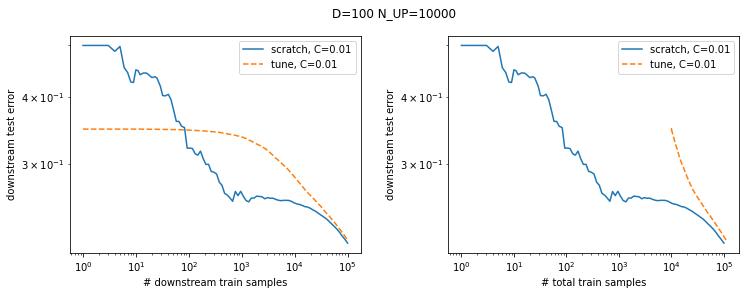

In [79]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)
plt.suptitle(f"{D=} {N_UP=}")

plt.subplot(1, 2, 1)
for C in [0.01]:
    errs_scratch, errs_tune = RESULTS[C]
    plt.plot(n_downs, errs_scratch, label=f"scratch, {C=}")
    plt.plot(n_downs, errs_tune, label=f"tune, {C=}", linestyle="--")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("# downstream train samples")
plt.ylabel("downstream test error")
plt.legend();

plt.subplot(1, 2, 2)
for C in [0.01]:
    errs_scratch, errs_tune = RESULTS[C]
    plt.plot(n_downs, errs_scratch, label=f"scratch, {C=}")
    plt.plot(N_UP + n_downs, errs_tune, label=f"tune, {C=}", linestyle="--")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("# total train samples")
plt.ylabel("downstream test error")
plt.legend();